# Нейронная сеть генерации подписей для изображений
Бакланова Екатерина Сергеевна

# Получение данных и анализ

In [44]:
import warnings
import pandas as pd

warnings.filterwarnings("ignore")

In [ ]:
# Для обучения (экономия памяти)

with open("C:/Users/Kat/Pictures/ds_image_paths.txt", "r", encoding="utf-8") as f:
    image_paths = [line.strip() for line in f.readlines()]

with open("C:/Users/Kat/Pictures/ds_texts.txt", "r", encoding="utf-8") as f:
    texts = [line.strip() for line in f.readlines()]


In [ ]:
import psutil

print(f"RAM used: {psutil.virtual_memory().percent}%")

RAM used: 69.0%


In [ ]:
# Для анализа

from datasets import load_dataset
ds = load_dataset("tomytjandra/h-and-m-fashion-caption")
df = ds['train'].to_pandas()
df.head(10)

,text,image
0,solid black jersey top with narrow shoulder st...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
1,solid black tights with built-in support to li...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
2,solid dark blue fitted top in soft stretch jer...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
3,melange dark grey trousers in sweatshirt fabri...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
4,solid black leggings in soft jersey with a wid...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
5,solid black 50 denier tights with reinforcemen...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
6,solid black 34-length leggings in stretch jers...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
7,solid black long-sleeved sports top in fast-dr...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
8,solid black opaque matt leggings with an elast...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
9,solid black semi shiny stay-ups with a wide la...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...


In [ ]:
from PIL import Image
import io

def bytes_to_image(image_bytes):
    return Image.open(io.BytesIO(image_bytes))

df_new = df.copy()
df_new['image'] = df_new['image'].apply(lambda x: bytes_to_image(x['bytes']))


                                                text  \
0  solid black jersey top with narrow shoulder st...   
1  solid black tights with built-in support to li...   
2  solid dark blue fitted top in soft stretch jer...   
3  melange dark grey trousers in sweatshirt fabri...   
4  solid black leggings in soft jersey with a wid...   
5  solid black 50 denier tights with reinforcemen...   
6  solid black 34-length leggings in stretch jers...   
7  solid black long-sleeved sports top in fast-dr...   
8  solid black opaque matt leggings with an elast...   
9  solid black semi shiny stay-ups with a wide la...   

                                               image  
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
2  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
3  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
4  <PIL.JpegImagePlugin.JpegImageFile image mode=...  
5  <PIL.JpegImagePlugin.JpegImageFile image mode=... 

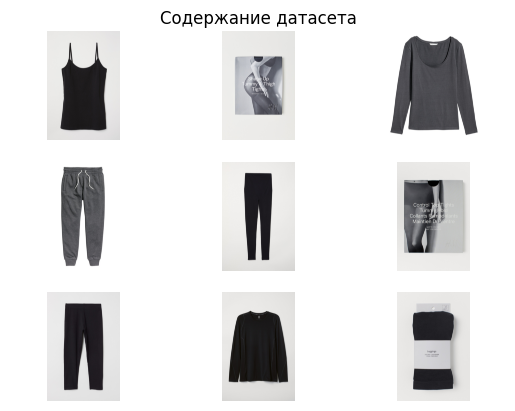

In [ ]:
import matplotlib.pyplot as plt

plt.axis('Off')
plt.title('Содержание датасета')
print(df_new.head(10))
for i, img in enumerate(df_new[:9]['image']):
    sp = plt.subplot(3, 3, i + 1)
    sp.axis('Off')
    plt.imshow(img)
plt.show()

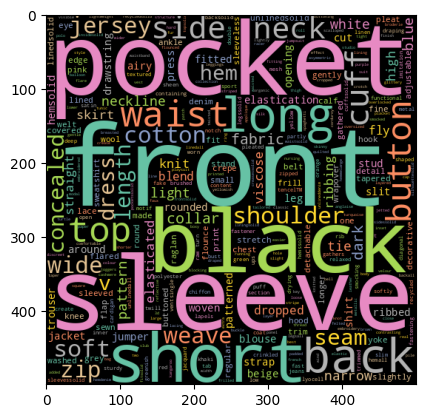

In [ ]:
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize

words_string = ""
for i in df_new['text']:
    words_string += i

wordCloud = WordCloud(width = 500, height = 500, random_state=1, max_words=1000, background_color='black', colormap='Set2', collocations=False).generate(words_string)
plt.imshow(wordCloud)

55


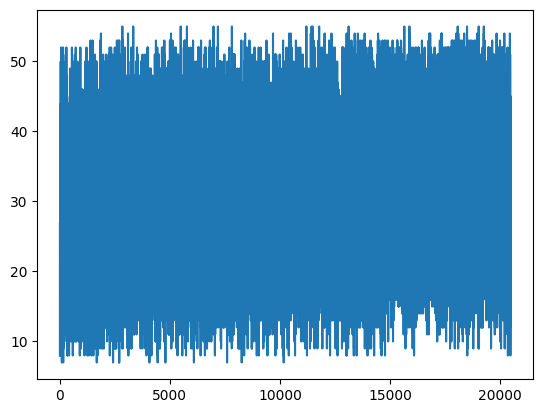

In [ ]:
max_len = 0
lengths = []
for caption in df_new['text']:
    len_caption = len(caption.split())
    if len_caption > max_len:
        max_len = len_caption
    lengths.append(len_caption)
print(max_len)
plt.plot(lengths)

In [ ]:
# Подключение библиотек

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from PIL import Image
from torch.utils.data import DataLoader

# Подготовка данных

Предобработка текстов: токенизация, приведение к нижнему регистру, удаление лишних символов, выравнивание
Предобработка изображений: изменение размера, приведение кк тензору, нормализация
Создание итератора

In [190]:
# Предобработка

def preprocess(text):
    text = text.lower()
    text = ''.join(filter(lambda x: x.isalpha() or x.isspace(), text))
    return text

In [ ]:
max_len = 0
lengths = []
for caption in df_new['text']:
    len_caption = len(caption.split())
    if len_caption > max_len:
        max_len = len_caption
    lengths.append(len_caption)
print(max_len)
plt.plot(lengths)

In [ ]:
# Выравнивание

pad_len = 55

print("Пример текста", texts[0])
for i, caption in enumerate(texts):
    caption = preprocess(caption)
    caption_len = len(caption.split())
    texts[i] = '<s> ' + caption + ' <e>' + ' <pad> '* (pad_len - caption_len)
    if len(texts[i].split())!= 57:
        print(len(texts[i].split()), texts[i])
    

solid black jersey top with narrow shoulder straps


In [192]:
# Сокращение размера

batch_size = 10

texts = texts[:2000]
image_paths = image_paths[:2000]

In [193]:
# Размер словаря

corpus = []
captions = []
for i in texts:
    captions.append(i)
    for j in i.split():
        corpus.append(j)

vocab = set(corpus)
vocab_size = len(vocab)
print("Размер словаря: ", vocab_size)

Размер словаря:  912


In [194]:
# Токенизация 

class CustomTokenizer:
    def __init__(self, num_words=None):
        self.word_index = {}
        self.index_word = {}
        self.num_words = num_words  
       

    def fit_on_texts(self, texts):
        words = []
        for text in texts:
            words.extend(text.split())
        
        self.word_index = {"<s>": 1, "<pad>": 0, "<e>": 2}
        
        idx = len(self.word_index)
        for word in words:
            if word not in self.word_index:
                self.word_index[word] = idx
                idx += 1
                if self.num_words and idx >= self.num_words:
                    break
        
        self.index_word = {v: k for k, v in self.word_index.items()}


    def texts_to_sequences(self, texts):
        for text in texts:
            seq = []
            for word in text.split():
                if word in self.word_index:
                    seq.append(self.word_index[word])
                else:
                    pass
        return seq

    def sequences_to_texts(self, sequences):
        return [" ".join([self.index_word.get(i) for i in seq]) for seq in sequences]

tokenizer = CustomTokenizer(num_words=vocab_size)

tokenizer.fit_on_texts(texts)

texts = [tokenizer.texts_to_sequences([x]) for x in texts]


In [195]:
import torch
import torchvision
from torch.utils.data import Dataset, random_split


transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),              
    torchvision.transforms.Normalize(               
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    ),
])

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform):
        self.images = images
        self.labels = labels
        
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image =  Image.open(image)
        label = self.labels[idx]
       
        if self.transform:
            image = self.transform(image)  
            
        return image, torch.LongTensor(label)
    

dataset = CustomDataset(image_paths, texts, transform=transform)

train_ratio = 0.8  # 80% train, 20% test
train_size = int(train_ratio * len(dataset))
val_test_size = (len(dataset) - train_size)

train_dataset, test_dataset = random_split(
    dataset,
    [train_size, val_test_size],
    generator=torch.Generator().manual_seed(42)  
)
test_ratio = 0.5  # 50% test, 50% val
test_size = int(test_ratio * len(test_dataset))
val_size = (len(test_dataset) - test_size)

test_dataset, val_dataset = random_split(
    test_dataset,
    [test_size, val_size],
    generator=torch.Generator().manual_seed(42)  
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,     
    pin_memory=True,
    shuffle=True,       
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,      
    pin_memory=True,
    shuffle=True,        
)

val_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,      
    pin_memory=True,
    shuffle=True,        
)

In [196]:
# Параметры модели

features_dim = 1280  
hidden_dim = 224     
embed_dim = 224
units = 224
num_layers = 1
seq_len = 57
device = torch.device("cuda")

# Архитектура модели

Содержит енкодер, декодер, механизм внимания

Энкодер представлен предобученной CNN efficientnet_b0 для извлечения признаков из изображений

In [38]:
import torch
from torch import nn
import torchvision.models as models
import torch.nn.functional as F


class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = models.efficientnet_b0(pretrained = True)
        self.features_extractor = nn.Sequential(*list(self.encoder.children())[:-2])      
        
    def forward(self, images):
        features = self.features_extractor(images)
        features = self.encoder.avgpool(features)  
        features = features.view(features.size(0), -1) 
        return features
        

Внимание рассчитывается по формуле Bahdanau

In [39]:

import seaborn as sns

class Attention(nn.Module):
    def __init__(self, hidden_dim, features_dim):
        super(Attention, self).__init__()
        
        self.features_dim = features_dim
        self.hidden_dim = hidden_dim
        self.W1 = nn.Linear(in_features=features_dim, out_features=hidden_dim)  
        self.W2 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)    
        self.V = nn.Linear(in_features=hidden_dim, out_features=1)              

        self.fc = nn.Linear(features_dim, embed_dim)
        
        
    def forward(self, features, hidden):
        
        hidden_with_time_axis = hidden.unsqueeze(1)
        score = torch.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = F.softmax(self.V(score), dim=1) 
        context_vector = attention_weights * features
        context_vector = torch.sum(context_vector, dim=1)
        context_vector = self.fc(context_vector)
        
        return context_vector

Декодер представлен LSTM

In [40]:
class Decoder(nn.Module):
    
    def __init__(self, features_dim, seq_len, hidden_dim, vocab_size, num_layers, embed_dim):
        super(Decoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.features_dim = features_dim
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        self.embed_dim = embed_dim
        
        self.attention = Attention(self.hidden_dim, self.features_dim)
        self.embed = nn.Embedding(vocab_size, self.embed_dim)

        self.lstm = nn.LSTM(embed_dim*2, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, captions, features, hidden, cell):
       
        context_vector = self.attention(features, hidden.squeeze(0))
        embed = self.embed(captions)  
        context_vector = context_vector.unsqueeze(1)
        lstm_input = torch.cat((context_vector, embed), dim=-1) 
        outputs, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))
        logits = self.fc(outputs)
        
        return logits, hidden, cell


Функция потерь для выравненных подписей

In [41]:

def loss_function(real, pred):

    mask = (real != 0).float()     
    loss_ = F.cross_entropy(pred, real, reduction='none')  
    loss_ = (loss_ * mask).sum()
   
    return loss_ / (mask.sum() + 1e-9)


Объединение моделей

Модель обрабатывает batch из подписей слово за словом, используя скрытое состояние LSTM
Также добавлен штраф за повторение токенов

In [42]:
class ImageCaptioner(nn.Module):
    def __init__(self, features_dim, seq_len, hidden_dim, vocab_size, num_layers, embed_dim):
        super().__init__()
        self.encoder = Encoder()
        self.num_layers = num_layers
        self.decoder = Decoder(features_dim, seq_len, hidden_dim, vocab_size, num_layers, embed_dim)
        
    def forward(self, images, captions, device, train_flag = 1):
        self.decoder = self.decoder.to(device)
        self.encoder = self.encoder.to(device)
        features = self.encoder(images)
               
        h = torch.zeros(self.num_layers, batch_size, hidden_dim).to(device)
        c = torch.zeros(self.num_layers, batch_size, hidden_dim).to(device)
        dec_input = torch.full((batch_size, 1), tokenizer.word_index['<s>'], dtype=torch.long).to(device)
        
        preds = []
        loss = 0
        predicted_sequence = torch.zeros((batch_size, seq_len), dtype=torch.long).to(device)
        for t in range(1, captions.shape[1]):
            predictions, h, c = self.decoder(dec_input, features, h, c)
            captions_loss = captions[:, t]
            predictions = predictions.squeeze(1) 

            if t > 0:  
                penalty = 1.5
                prev_preds = predicted_sequence[:, :t]  
                repeated_mask = (prev_preds.unsqueeze(2) == torch.arange(predictions.size(1), 
                                device=predictions.device).view(1, 1, -1))
                repeated_mask = repeated_mask.any(dim=1)  
                predictions = torch.where(repeated_mask, predictions/penalty, predictions)

            preds.append(predictions)
            loss += loss_function(captions_loss, predictions)
            predicted_sequence[:, t] = predictions.argmax(1)
            if train_flag:
                # Teacher forcing при train
                dec_input = captions[:, t].unsqueeze(1)
            else:
                # Предыдущее слово для test
                dec_input = torch.argmax(predictions, dim=1, keepdim=True)

        avg_loss = loss / (captions != 0).sum().item()
        return avg_loss, preds

Обучение модели

In [ ]:

import time
from tqdm import tqdm
import gc 
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
import nltk
from IPython.display import clear_output

clear_output(wait=True)  
nltk.download('wordnet')

idx2word = {idx: word for idx, word in tokenizer.index_word.items()}

# Формулы перевода тензоров в подписи
def tensor_pred_to_text(pred_tensor):
    batch_size = pred_tensor.size(1)
    captions = [[] for _ in range(batch_size)]
    
    # Берём argmax по последней оси (vocab_size)
    predicted_indices = torch.argmax(pred_tensor, dim=-1)  
    predicted_indices = predicted_indices.permute(1, 0)     
    
    for j in range(batch_size):
        for idx in predicted_indices[j]:
            idx = idx.item()
            if idx == 2:  # Стоп-токен
                break
            if idx not in (0, 1):  # Игнорируем паддинг и спецтокены
                captions[j].append(idx2word[idx])
    return captions

def tensor_target_to_text(pred_tensor):
    captions = [[] for _ in range(batch_size)]
    predicted_indices = [[] for _ in range(batch_size)]
    
    for i in range(batch_size):
        predicted_indices[i] = pred_tensor[i]
    
    for j, idx in enumerate(predicted_indices):  
        for i in idx:
            i = i.item()
            if i == 2:  
                break
            if i not in (1, 0):  
                captions[j].append(idx2word[i])
    return captions


LEARNING_RATE = 0.001
epochs = 21

total_steps = len(train_dataloader) * epochs
start_time = time.time()
completed_steps = 0
step_times = []
train_losses = []
val_losses = []

torch.cuda.empty_cache()
print(f"Using device: {device}")

# Модель и ее параметры
model = ImageCaptioner(features_dim, seq_len, hidden_dim, vocab_size, num_layers, embed_dim).to(device)
optimizer = torch.optim.Adam( params=[
        {"params": model.decoder.parameters()},
        {"params": model.encoder.parameters()},  
    ], lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.CrossEntropyLoss()   
BLEU_list = []
METEOR_list = []

with tqdm(total=total_steps, desc="Training") as pbar:
    for epoch in range(epochs):
        model.train()
        for batch_idx, (images, captions) in enumerate(train_dataloader):
           
            images = images.to(device)
            captions = captions.to(device)
                        
            step_start = time.time()
            optimizer.zero_grad()
            caption_lengths = 57
            
            avg_loss, _  = model(images, captions, device, 1) 
            train_losses.append(avg_loss.item())           
            avg_loss.backward()
                      
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            # очищение памяти
            torch.cuda.empty_cache()
            gc.collect()
            
            # отображение прогресса              
            if batch_idx % 100 == 0 and batch_idx > 0:
                print("train LOSS =", avg_loss)
                pbar.set_postfix({"epoch": f"{epoch}"})
                pbar.update(100)
                  
        model.eval() 
        correct = 0
        depred = [[] for _ in range(batch_size)]
        with torch.no_grad():
            for batch_idx, (images, captions) in enumerate(val_dataloader):
                images = images.to(device)
                captions = captions.to(device)
                
                avg_loss, preds = model(images, captions, device)  
                val_losses.append(avg_loss.item())   
                
                if batch_idx % 100 == 0 and batch_idx > 0:
                    print("val LOSS =", avg_loss)
                
                for i in range(batch_size):
                    for j in range(batch_size):
                        depred[j].append(preds[i])
               
                depred = torch.stack(preds)
                target = tensor_target_to_text(captions)
                depred = tensor_pred_to_text(depred)

                for i in range(batch_size):
                    BLEU_list.append(sentence_bleu([target[i]], depred[i]))
                    METEOR_list.append(meteor_score([target[i]], depred[i]))
                
        scheduler.step()   
        

In [ ]:
plt.plot(train_losses)

plt.xlabel('Итерация')
plt.ylabel('LOSS')
plt.title('Потери при обучении')
plt.show()
print(train_losses[-1])

plt.plot(val_losses, c='orange')
plt.xlabel('Итерация')
plt.ylabel('LOSS')
plt.title('Потери при валидации')
plt.show()
print(val_losses[-1])

In [ ]:
model.eval() 
correct = 0
depred = [[] for _ in range(batch_size)]
test_losses = []
with torch.no_grad():
            for batch_idx, (images, captions) in enumerate(test_dataloader):
                images = images.to(device)
                captions = captions.to(device)
                
                avg_loss, preds = model(images, captions, device, 0)  
                test_losses.append(avg_loss.item())   
                
                print("test LOSS =", avg_loss)
                
                for i in range(batch_size):
                    for j in range(batch_size):
                        depred[j].append(preds[i])
               
                depred = torch.stack(preds)
                target = tensor_target_to_text(captions)
                depred = tensor_pred_to_text(depred)

                for i in range(batch_size):
                    BLEU_list.append(sentence_bleu([target[i]], depred[i]))
                    METEOR_list.append(meteor_score([target[i]], depred[i]))

print("METEOR avg: ", sum(METEOR_list)/len(METEOR_list))
print("BLEU avg: ", sum(BLEU_list)/len(BLEU_list))